In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from import_casa import casa

In [4]:
import pandas as pd
import pickle
from gensim.models import FastText

In [5]:
spm_centroids = pd.read_csv(casa.get_data_path() / "eda/spm/spm_centroids.csv", index_col=None)
with open(casa.get_data_path()/"eda/spaCy_pipeline/raw-data-cht-2020-ppline.pkl", "rb") as fin:
    data = pickle.load(fin)

In [61]:
spm_centroids

,Unnamed: 0,cluster_idx,cluster_size,centroid,words
0,0,274,19,bile,ay my line Line LINE Mobile riDay mobile Hami ...
1,1,118,21,中華電信,遠傳 中華電信 亞太 台灣之星 台灣大哥大 亞太電信 台灣大 中華電 遠傳的 遠傳電信 跟遠...
2,2,182,19,12pro,Pro 11 25 iphone pro 128 128G iphone12 12Pro a...
3,3,270,17,Pixel,支援 Pixel Google 顯示 心得 三星 google 小米 版本 pixel 4a...
4,4,192,31,12、iPhone,12 iPhone 預購 iPhone12 預約 新機 推出 開放 各 、遠傳 各家 的iP...
...,...,...,...,...,...
153,153,228,15,久,快 滿 久 多了 好用 後悔 鮮 夯 迅 豔 嚐 譜 挾 巔 冗
154,154,98,15,爭,代 取 利 屬 便 超商 爭 全家 索 宅配 暖 礙 潤 擷 侷
155,155,27,46,車站,區 台北 山 北 南 隔 離 島 車站 嘉 台南 高雄 台北市 湖 壁 蘭 桃園 橋 宜蘭 ...
156,156,303,36,樵,XD DD XDD 瞎 ㄌ 吹 辣 削 ㄛ ㄅ 賊 樁 😃 爹 奸 抹 拎 甩 賤 尛 錒 ...


In [62]:
centroid_lists = "中華電信,12pro,Pixel,1399元,24個月,199,LTE,3000,方案,5G,划算,電信業者,用中華,21M,攜碼".split(",")

In [8]:
path = casa.get_data_path() / "eda/spm/sp_vectors.model"
model = FastText.load(str(path))
model.wv.vectors.shape

[INFO] 2020-12-22 21:42:33,403 gensim.utils: loading FastText object from E:\LangOn\casa\data\eda\spm\sp_vectors.model
[INFO] 2020-12-22 21:42:33,568 gensim.utils: loading wv recursively from E:\LangOn\casa\data\eda\spm\sp_vectors.model.wv.* with mmap=None
[INFO] 2020-12-22 21:42:33,568 gensim.utils: loading vectors_ngrams from E:\LangOn\casa\data\eda\spm\sp_vectors.model.wv.vectors_ngrams.npy with mmap=None
[INFO] 2020-12-22 21:42:36,875 gensim.utils: setting ignored attribute vectors_ngrams_norm to None
[INFO] 2020-12-22 21:42:36,875 gensim.utils: setting ignored attribute vectors_norm to None
[INFO] 2020-12-22 21:42:36,876 gensim.utils: setting ignored attribute vectors_vocab_norm to None
[INFO] 2020-12-22 21:42:36,876 gensim.utils: setting ignored attribute buckets_word to None
[INFO] 2020-12-22 21:42:36,877 gensim.utils: loading vocabulary recursively from E:\LangOn\casa\data\eda\spm\sp_vectors.model.vocabulary.* with mmap=None
[INFO] 2020-12-22 21:42:36,877 gensim.utils: loading 

(5885, 100)

In [84]:
from collections import Counter
from tqdm.auto import tqdm


def find_targets(dep_data, seeds, wv):
    try:
        words = [x[0] for x in dep_data]    
        pots = casa.compute_potentials(words, seeds, wv)
        targets, targ_indices = casa.extract_with_potentials(words, pots)        
    except Exception as ex:
        print(ex)
        targets = []
    return targets

def extract_targets(data, seeds, centroid):
    target_list = []

    for data_item in tqdm(data, desc=centroid):    
        # titles
        if data_item.main and data_item.main.title_tree:
            target_list.extend(find_targets(data_item.main.title_tree, seeds, model.wv))

        # replies
        for reply_x in data_item.replies:
            if not reply_x.text_tree: continue
            target_list.extend(find_targets(reply_x.text_tree, seeds, model.wv))
    return Counter(target_list)

In [83]:
seeds = spm_centroids.loc[spm_centroids.centroid==centroid_lists[0]].iloc[0].words.split()

In [91]:
lexicon = {}
for centroid in centroid_lists:
    sub_df = spm_centroids.loc[spm_centroids.centroid==centroid]
    seeds = sub_df.iloc[0].words.split()
    lexicon[centroid] = extract_targets(data, seeds, centroid)

In [90]:
with open(casa.get_data_path() / "eda/spm/spm_lexicon_1.pkl", "wb") as fout:
    pickle.dump(lexicon, fout)

In [94]:
fout = open(casa.get_data_path() / "eda/spm/spm_lexicon_1.md", "w", encoding="UTF-8")
fout.write("# CHT-ABSA Coarsed-lexicion [Iteration I]\n")
for centroid, counter in lexicon.items():
    fout.write(f"## {centroid}\n")
    fout.write("\u3000".join(f"{x[0]}({x[1]})" 
                             for x in counter.most_common(100)))
    fout.write("\n")
    fout.write("\n")
fout.close()

## visualizing

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

In [57]:
words = [x[0] for x in data[1].main.title_tree]    
seeds = spm_centroids.iloc[1].words.split()
pots = casa.compute_potentials(words, seeds, model.wv)
targets, targ_indices = casa.extract_with_potentials(words, pots)  

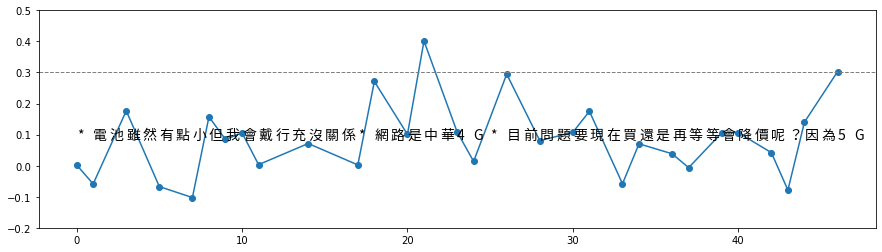

In [58]:
import numpy as np
font = FontProperties(fname=casa.get_data_path() / "NotoSansCJK-Regular.ttc", size=14)
from itertools import chain
s = 60
win = slice(s, s+30)
words_sub = words[win]
counter = 0
pots_xs = []
base_y = np.mean(pots[win])
for word in words_sub:
    pots_xs.append(counter)
    for char in word:
        plt.text(counter, base_y, char, fontproperties=font)
        counter += 1
plt.plot(pots_xs, pots[win], 'o-')
plt.ylim(-0.2,.5)
plt.axhline(0.3, color="gray", linestyle='--', linewidth=1)
plt.gcf().set_figwidth(15)